In [34]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime




current_date = datetime(2023, 3, 3)

r = 0.0425
q = 0.0053
S = 151.03

portfolios = pd.read_csv("problem3.csv", parse_dates=["ExpirationDate"])


def gbsm(option_type, S, X, T, sigma, r, q):

  d1 = (np.log(S/X) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  if option_type == 'Call':
    is_call = 1
  else:
    is_call = -1
    
  price = is_call * (S * np.e ** ((q - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
  return price
   

    
def implied_vol(option_type, S, X, T, r, q, market_price, x0=0.5):
    def equation(sigma):
        return gbsm(option_type, S, X, T, sigma, r, q) - market_price
    
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]


# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
  option_type = portfolios["OptionType"][i]
  X = portfolios["Strike"][i]
  T = (portfolios["ExpirationDate"][i] - current_date).days / 365
  market_price = portfolios["CurrentPrice"][i]
  sigma = implied_vol(option_type, S, X, T, r, q, market_price)
  implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

print(portfolios)

       Portfolio    Type Underlying  Holding OptionType ExpirationDate  \
0       Straddle  Option       AAPL        1       Call     2023-04-21   
1       Straddle  Option       AAPL        1        Put     2023-04-21   
2        SynLong  Option       AAPL        1       Call     2023-04-21   
3        SynLong  Option       AAPL       -1        Put     2023-04-21   
4     CallSpread  Option       AAPL        1       Call     2023-04-21   
5     CallSpread  Option       AAPL       -1       Call     2023-04-21   
6      PutSpread  Option       AAPL        1        Put     2023-04-21   
7      PutSpread  Option       AAPL       -1        Put     2023-04-21   
8          Stock   Stock       AAPL        1        NaN            NaT   
9          Call   Option       AAPL        1       Call     2023-04-21   
10          Put   Option       AAPL        1        Put     2023-04-21   
11   CoveredCall   Stock       AAPL        1        NaN            NaT   
12   CoveredCall  Option       AAPL   

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [37]:
def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      value = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      S = sim_prices
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      sigma = portfolios["ImpliedVol"][i]
      option_values = gbsm(option_type, S, X, T, sigma, r, q)
      value = option_values
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * value
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()
     

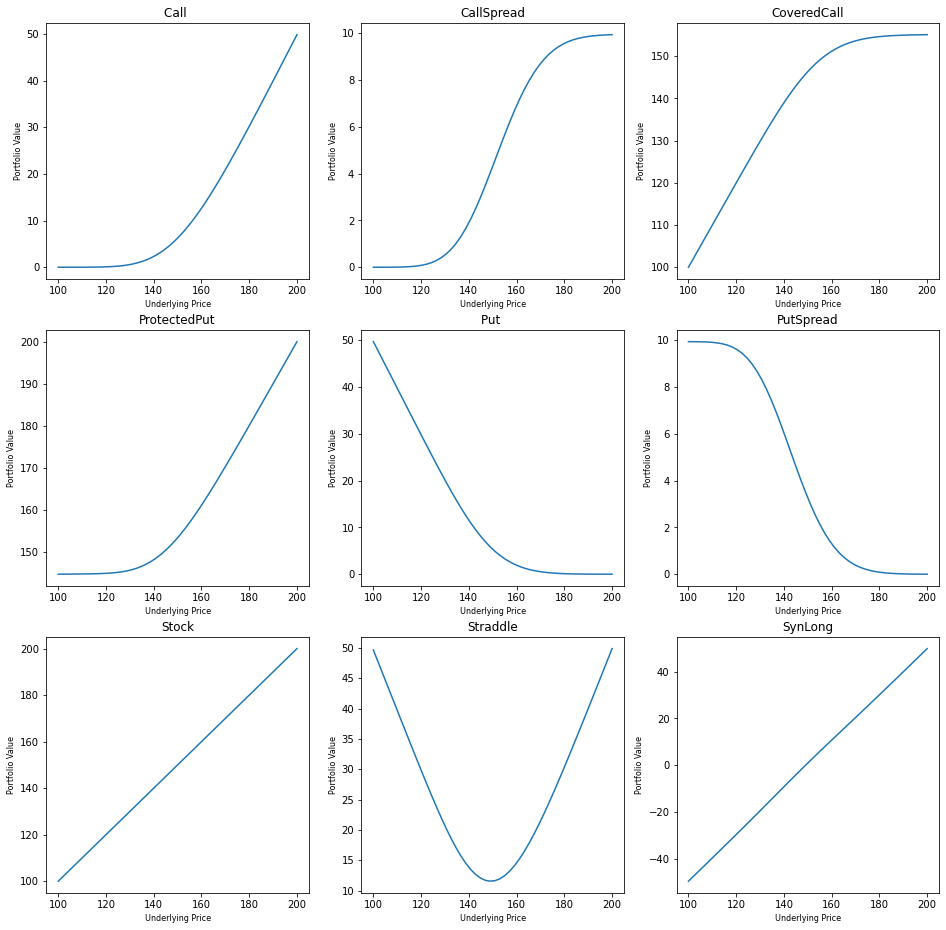

In [40]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(100, 200, 50)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

                  mean       var        es
Portfolio                                 
Call          0.000035 -0.036817 -0.032291
CallSpread    0.000035 -0.036817 -0.032291
CoveredCall   0.000035 -0.036817 -0.032291
ProtectedPut  0.000035 -0.036817 -0.032291
Put           0.000035 -0.036817 -0.032291
PutSpread     0.000035 -0.036817 -0.032291
Stock         0.000035 -0.036817 -0.032291
Straddle      0.000035 -0.036817 -0.032291
SynLong       0.000035 -0.036817 -0.032291


In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Step 1: Load the data into a DataFrame
df = pd.read_csv('DailyPrices.csv')

# Step 2: Extract the daily closing prices for AAPL
aapl_prices = df['AAPL']
#print(aapl_prices)

# Step 3: Calculate the log returns of AAPL
log_returns = np.log(aapl_prices) - np.log(aapl_prices.shift(1))

# Step 4: Demean the log returns
demeaned_log_returns = log_returns - np.mean(log_returns)

# Step 5: Fit an AR(1) model to the demeaned log returns
ar1_model = sm.tsa.ARIMA(demeaned_log_returns, order=(1,0,0))
result = ar1_model.fit()

#Step 6: Simulate 10 days of log returns for AAPL
mu = np.mean(demeaned_log_returns)
sigma = np.std(demeaned_log_returns)
simulated_log_returns = np.random.normal(mu, sigma, 10)
print(simulated_log_returns)

# Step 7: Calculate the mean, VaR, and ES of the simulated log returns
result = pd.DataFrame(index=sim_value_changes.index)

result['mean'] = np.mean(simulated_log_returns)
result['var'] = np.percentile(simulated_log_returns, 5)
result['es'] = np.mean(simulated_log_returns[simulated_log_returns <= var])

print(result)

[ 0.03339887 -0.0147353   0.01254406 -0.01149427 -0.01054707  0.03599468
 -0.03098425  0.05099287  0.03098324 -0.02105608]
                 mean       var       es
Portfolio                               
Call          0.00751 -0.026517 -0.02602
CallSpread    0.00751 -0.026517 -0.02602
CoveredCall   0.00751 -0.026517 -0.02602
ProtectedPut  0.00751 -0.026517 -0.02602
Put           0.00751 -0.026517 -0.02602
PutSpread     0.00751 -0.026517 -0.02602
Stock         0.00751 -0.026517 -0.02602
Straddle      0.00751 -0.026517 -0.02602
SynLong       0.00751 -0.026517 -0.02602
